### Cloud Classifier based on PyTorch Lightning

dataset used from: https://www.kaggle.com/competitions/cloud-type-classification2

To execute the notebook you need to download the dataset, from the kaggle competition site, with the command:

kaggle competitions download -c cloud-type-classification2

and unzip the downloaded file in $BASE_DIR

In this NB we use EffNetB2

In [1]:
from os import path
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import Accuracy

# the backbone
from torchvision.models import efficientnet_b2

sns.set()

%matplotlib inline

In [2]:
SEED = 42
torch.manual_seed(SEED)

# globals
BATCH_SIZE = 16
EPOCHS = 16

# for train dataloader.
NUM_WORKERS = 12

# size of the image we're working on for EffNetB2
IMAGE_SIDE = 260

# the base_dir inside which we unzip the file from Kaggle
BASE_DIR = "/home/datascience/clouds_classification_data/"

IMAGES_TRAIN = path.join(BASE_DIR, "images/train/")
IMAGES_TEST = path.join(BASE_DIR, "images/test/")

# the file with image_name, label
FILE_TRAIN = path.join(BASE_DIR, "train.csv")

In [3]:
# here we read the csv with all file name + labes
train_csv_df = pd.read_csv(FILE_TRAIN)

# count the number of classes
# cirriform clouds,high cumuliform clouds,stratocumulus clouds,cumulus clouds,cumulonimbus clouds,stratiform clouds,clear sky
N_CLASSES = train_csv_df['label'].nunique()

In [4]:
print(f"The number of classes is: {N_CLASSES}")

The number of classes is: 7


#### Image trasformations (also for augmentation, applied only to train set)

In [5]:
# I'm using mean and std for ImageNet
MEANS = [0.485, 0.456, 0.406]
STDS = [0.229, 0.224, 0.225]

# removed vertical flip, some clouds are recognized from what is on top
def get_train_transform():
    return T.Compose(
        [
            T.Resize((IMAGE_SIDE, IMAGE_SIDE)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(25),
            T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
            T.ToTensor(),
            T.Normalize(mean=MEANS, std=STDS),
        ]
    )

# val transforms doesn't make augmentation: we want to validate every time
# on the same images
def get_val_transform():
    return T.Compose(
        [
            T.Resize((IMAGE_SIDE, IMAGE_SIDE)),
            T.ToTensor(), 
            T.Normalize(mean=MEANS, std=STDS)
        ]
    )

#### The custom dataset

In [6]:
# pass as input the train dataframe
class CloudsDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df
        # list with imgs names
        self.imgs = df['id'].values
        self.labels = df['label'].values
        self.transforms = transforms

    def __getitem__(self, idx):
        full_image_name = path.join(IMAGES_TRAIN, self.imgs[idx])
        
        img = Image.open(full_image_name)
        
        if self.transforms is not None:
            img = self.transforms(img)

        # get the label
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)
        
        return img, label

    def __len__(self):
        return len(self.imgs)

#### Datasets and DataLoaders

In [7]:
# split in train and validation
# added shuffling (LS, 9/11/2022)

# the dataset is small, I'm using only 10% for validation
VAL_FRAC = 0.1

train_df_used, val_df_used = train_test_split(train_csv_df, shuffle= True, test_size=VAL_FRAC)

print("Train/validation split:")
print(f"We have {len(train_df_used)} imgs for training")
print(f"We have {len(val_df_used)} imgs for validation")

Train/validation split:
We have 864 imgs for training
We have 96 imgs for validation


In [8]:
# datasets
train_ds = CloudsDataset(train_df_used, transforms=get_train_transform())
val_ds = CloudsDataset(val_df_used, transforms=get_val_transform())

# data loaders
train_dl = DataLoader(
    dataset=train_ds, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)

val_dl = DataLoader(
    dataset=val_ds, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=False
)

#### The Lightning Model based on EffNetB2

we're using the EffNetB2 from TorchVision

In [9]:
class LitCloudClassifierB2(LightningModule):
    def __init__(self, learning_rate=0.0001):

        super().__init__()

        # Set our init args as class attributes
        self.lr = learning_rate

        # dataset specific attributes
        self.num_classes = N_CLASSES
        
        # Define PyTorch model: a simple CNN
        self.model = efficientnet_b2(pretrained=True)
        # changed to 1408 for B2
        self.model.classifier[1] = nn.Sequential(nn.Linear(1408, self.num_classes, bias=True))

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        # the model outputs logits not probabilities
        # this is better for numerical stability
        x = self.model(x)
        return F.log_softmax(x, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        # for now fixed LR
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        return optimizer

In [10]:
checkpoint_callback = ModelCheckpoint(dirpath="checkpoint_clouds", save_top_k=1, monitor="val_loss",
                                     mode="min",
                                     filename="clouds-{epoch:02d}-{val_loss:.2f}")

In [11]:
model = LitCloudClassifierB2()

trainer = Trainer(
    accelerator="auto",
    # we can choose to use mixed precision, to reduce mem. footprint
    precision=16,
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=EPOCHS,
    callbacks=[TQDMProgressBar(refresh_rate=5), checkpoint_callback],
    logger=CSVLogger(save_dir="logs/"),
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, train_dl, val_dl)

/home/datascience/conda/computervision_p37_gpu_v1/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datascience/pytorch-on-oci/ch-04/checkpoint_clouds exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | model         | EfficientNet | 7.7 M 
1 | val_accuracy  | Accuracy     | 0     
2 | test_accuracy | Accuracy     | 0     
-----------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
15.422    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.


#### Plot metrics during the epochs

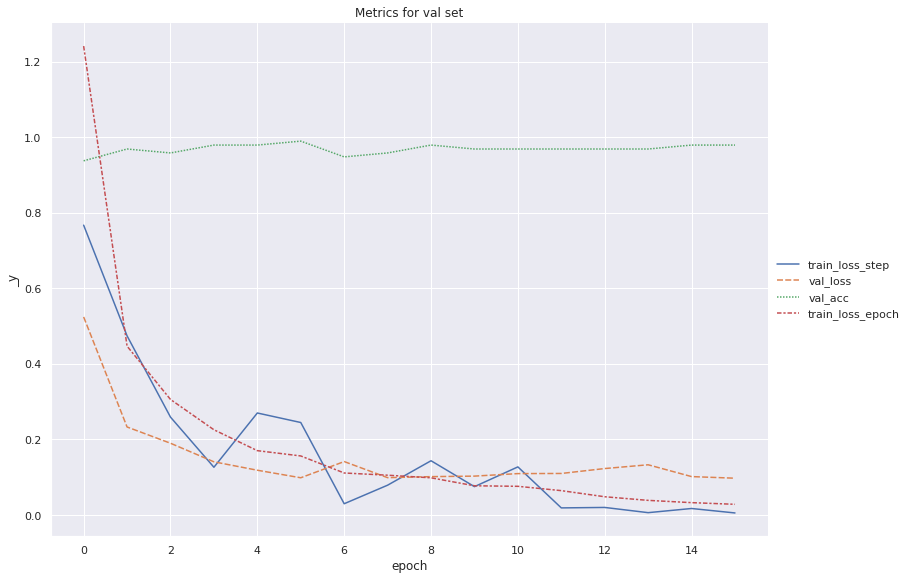

In [13]:
# get metrics from the logs
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)

# if you want also in tabular format
# display(metrics.dropna(axis=1, how="all").tail(10))

sns.set(rc={'figure.figsize':(12,12)})

sns.relplot(data=metrics, kind="line",
           height=8, aspect=11/8).set(title='Metrics for val set');
plt.grid(True)
plt.show();

#### Test: reload the Best Model and test

In [14]:
# put here the name of the best checkpoint file
model = LitCloudClassifierB2.load_from_checkpoint("./checkpoint_clouds/bestb206022023.ckpt")

In [15]:
trainer.test(model, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9791666865348816
        test_loss           0.09755022078752518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.09755022078752518, 'test_acc': 0.9791666865348816}]

#### let's see the errors on the entire validation set

could be improved using batch, but since val_set is small it is ok

In [16]:
n_test = len(val_ds)
n_ok = 0

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.eval()
model.to(device)

for i in tqdm(range(n_test)):
    img, label = val_ds[i]

    img_batch = img.unsqueeze(0)
    img_batch = img_batch.to(device)
    
    with torch.no_grad():
        preds = model(img_batch)

    class_predicted = torch.argmax(preds, dim=1)
    
    # otherwise are tensors
    label = label.item()
    class_predicted = class_predicted.item()
    
    if class_predicted == label:
        n_ok += 1
    else:
        print(f"Expected: {label}, predicted: {class_predicted}")
        
print()
print(f"Tot. OK: {n_ok} over: {n_test}")
print()

 39%|███▊      | 37/96 [00:07<00:11,  5.30it/s]

Expected: 1, predicted: 2


 51%|█████     | 49/96 [00:10<00:12,  3.91it/s]

Expected: 2, predicted: 1


100%|██████████| 96/96 [00:20<00:00,  4.60it/s]


Tot. OK: 94 over: 96



#### Prepare Submission for Kaggle

In [ ]:
IMAGES_TEST = BASE_DIR +"images/test/"
FILE_TEST = BASE_DIR + "test.csv"

test_df = pd.read_csv(FILE_TEST)

In [ ]:
test_imgs = list(test_df['id'].values)

print()

In [ ]:
#### here we create a custom dataset for test (no labels)

In [ ]:
class CloudsTestDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        # list with imgs names
        self.imgs = df['id'].values
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        full_image_name = IMAGES_TEST + self.imgs[idx]
        
        img = Image.open(full_image_name)
        # OK for EfficientNet B0
        # if scaling to another EffNet change the size here!
        img = self.transforms(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [ ]:
test_ds = CloudsTestDataset(test_df, transforms=get_val_transform())

#### Predictions for all test images

In [ ]:
model.eval()
model.to(device)

list_preds = []

for i in tqdm(range(len(test_ds))):
    img = test_ds[i]

    img_batch = img.unsqueeze(0)
    img_batch = img_batch.to(device)
    
    preds = model(img_batch)

    class_predicted = torch.argmax(preds)
    class_predicted = class_predicted.item()
    
    list_preds.append(class_predicted)

#### Get a file with the class_num for each jpg image

In [ ]:
dict_sub = {"id": test_imgs, 
           "predict": list_preds}

df_sub = pd.DataFrame(dict_sub)

df_sub.to_csv("submit04.csv", index=None)